# --- ENVIRONMENT INITIALIZATION ---

**Using the latest Vertex AI and BigQuery SDKs to ensure compatibility with the Google Cloud Python 3.12 runtime.**

In [ ]:
# Install the necessary Google Cloud AI Platform (Vertex AI) SDK and pin scikit-learn version for deployment compatibility
!pip install --upgrade --quiet google-cloud-aiplatform google-cloud-bigquery


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.43.0, but you have google-auth 2.47.0 which is incompatible.


In [ ]:
# 1. Authenticate the user (Secure OAuth)
from google.colab import auth
auth.authenticate_user()

# 3. Import necessary libraries
import os
import pandas as pd
from google.cloud import aiplatform
from google.cloud import bigquery

# 4. Define your project details
PROJECT_ID = "alan-marketing-project-123"
REGION = "us-central1"

# 5. Initialize the specific clients
# This client handles your data pulling (Step 1)
bq_client = bigquery.Client(project=PROJECT_ID)

# This client handles your model training and deployment (Step 3-5)
aiplatform.init(project=PROJECT_ID, location=REGION)

print(f"✅ Environment initialized for project: {PROJECT_ID}")

✅ Environment initialized for project: alan-marketing-project-123


# Task
Build and deploy a machine learning model to predict user purchase probability. This involves ingesting data from the 'users' and 'events' tables within the 'TheLook Ecommerce' BigQuery dataset, performing exploratory data analysis, preprocessing features (including creating a 'session_intensity' feature), training a `RandomForestClassifier`, evaluating its performance, and finally deploying the trained model to Vertex AI for mock predictions.

## Initialize Vertex AI Client

### Subtask:
Initialize the Vertex AI client using the authenticated GCP project ID.


**Reasoning**:
To initialize the Vertex AI client: import the `vertexai` library and then call `vertexai.init()` with the previously obtained `project_id`.



In [ ]:
import vertexai

vertexai.init(project=PROJECT_ID)

print(f"Vertex AI SDK initialized for project: {PROJECT_ID}")

Vertex AI SDK initialized for project: alan-marketing-project-123


## Data Ingestion (BigQuery)

### Subtask:
Formulate a SQL query to join 'users' and 'events' tables from 'TheLook Ecommerce' dataset in BigQuery, load the query result into a Pandas DataFrame, and explain the chosen features.


In [ ]:
sql_query = """
SELECT
    t1.id AS user_id,
    t1.age,
    t1.gender,
    t1.state,
    t1.country,
    t1.traffic_source,
    COUNT(DISTINCT t2.session_id) AS total_sessions,
    COUNTIF(t2.event_type = 'purchase') AS total_purchases,
    COUNT(DISTINCT t2.uri) AS total_page_views,
    COUNT(t2.event_type) AS total_events
FROM
    `bigquery-public-data.thelook_ecommerce.users` AS t1
LEFT JOIN
    `bigquery-public-data.thelook_ecommerce.events` AS t2
ON
    t1.id = t2.user_id
GROUP BY
    t1.id, t1.age, t1.gender, t1.state, t1.country, t1.traffic_source
"""

# Execute the corrected query and load into DataFrame
df = bq_client.query(sql_query).to_dataframe()

# Display DataFrame info and head
print("DataFrame Info:")
df.info()
print("\nDataFrame Head:")
print(df.head())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           100000 non-null  Int64 
 1   age               100000 non-null  Int64 
 2   gender            100000 non-null  object
 3   state             100000 non-null  object
 4   country           100000 non-null  object
 5   traffic_source    100000 non-null  object
 6   total_sessions    100000 non-null  Int64 
 7   total_purchases   100000 non-null  Int64 
 8   total_page_views  100000 non-null  Int64 
 9   total_events      100000 non-null  Int64 
dtypes: Int64(6), object(4)
memory usage: 8.2+ MB

DataFrame Head:
   user_id  age gender      state country traffic_source  total_sessions  \
0      687   63      F  São Paulo  Brasil         Search               5   
1    17405   67      M    Beijing   China        Organic               8   
2    41390   48

## Exploratory Data Analysis (EDA)

### Subtask:
Generate a correlation heatmap to visualize the relationship between 'sessions' and 'purchases' in the DataFrame. Create a histogram to plot the distribution of user ages and identify any outliers.

**Reasoning**:
To understand the relationship between user engagement (sessions) and purchasing behavior. This will help visualize how `total_sessions` and `total_purchases` are linearly related. Additionally a histogram to understand the demographic distribution and identify potential outliers. These visualizations are crucial for gaining initial insights into the data.

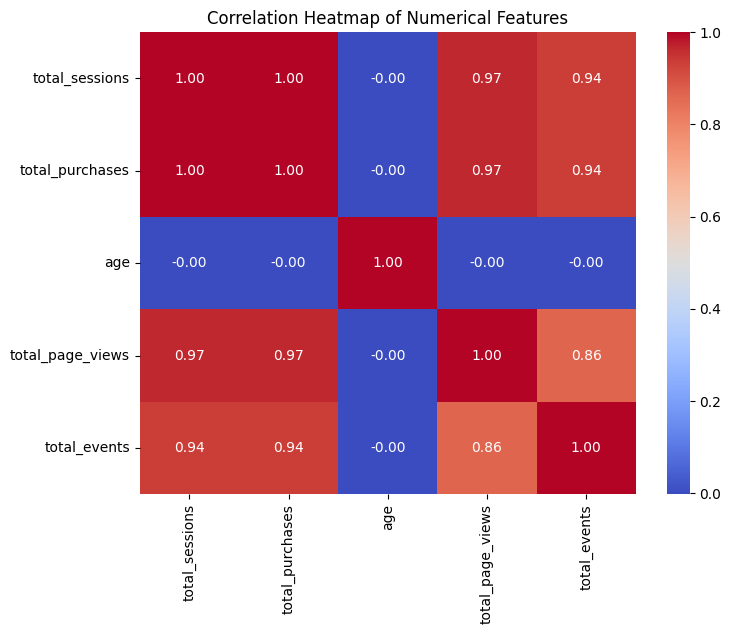

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns for correlation analysis
correlation_cols = ['total_sessions', 'total_purchases', 'age', 'total_page_views', 'total_events']
corr_matrix = df[correlation_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### User Age Distribution

To understand the demographic distribution of our users and identify potential outliers, we will create a histogram of the `age` column.

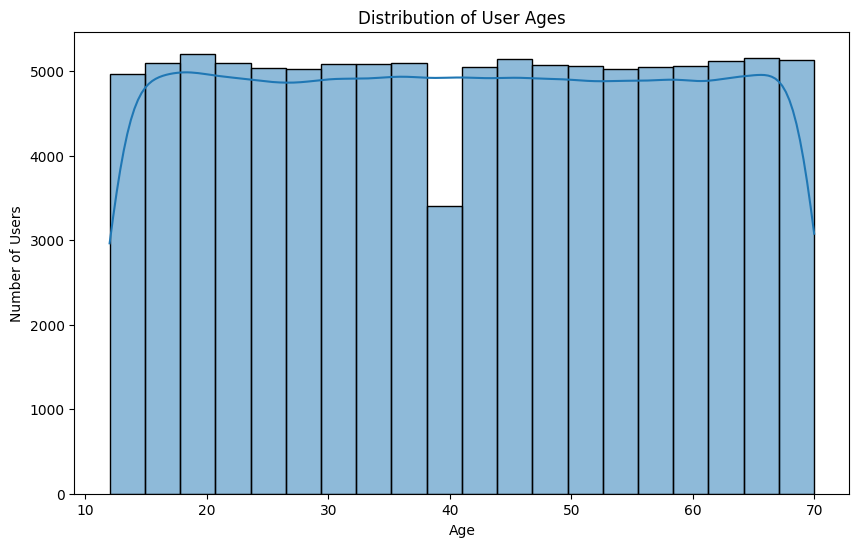

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

### Sessions vs. Purchases Scatter Plot

To further explore the relationship between user engagement and purchasing behavior, I will create a scatter plot of `total_sessions` against `total_purchases`.

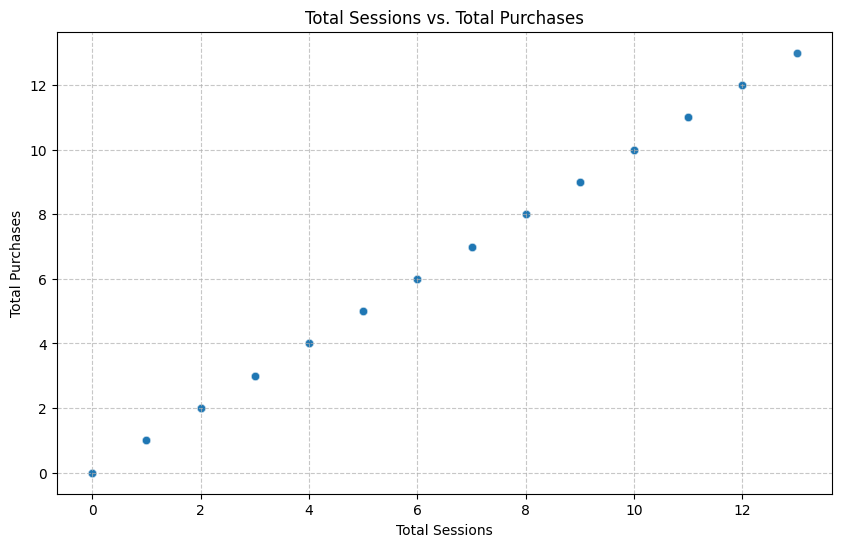

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_sessions', y='total_purchases', data=df, alpha=0.6)
plt.title('Total Sessions vs. Total Purchases')
plt.xlabel('Total Sessions')
plt.ylabel('Total Purchases')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**Reasoning**:
To prepare the data for model training, we will engineer a new feature called `session_intensity` by dividing `total_events` by `total_sessions`. This aims to capture how active a user is within their sessions. Next, we will identify and apply one-hot encoding to categorical features using `pd.get_dummies` to convert them into a numerical format suitable for machine learning models. Finally, we will scale the numerical features using `StandardScaler` to normalize their ranges, preventing features with larger values from dominating the learning process.

In [ ]:
# Engineering: Creating 'session_intensity'
# Avoid division by zero by replacing 0 total_sessions with 1 before division, or handling NaNs if they arise.
df['session_intensity'] = df['total_events'] / df['total_sessions']
df['session_intensity'] = df['session_intensity'].fillna(0) # Fill NaN with 0 if total_sessions was 0 and resulted in NaN

print("DataFrame with 'session_intensity' feature:")
display(df[['total_events', 'total_sessions', 'session_intensity']].head())

DataFrame with 'session_intensity' feature:


,total_events,total_sessions,session_intensity
0,44,5,8.8
1,76,8,9.5
2,85,9,9.444444
3,44,5,8.8
4,76,8,9.5


In [ ]:
from sklearn.preprocessing import StandardScaler

# Separate target variable 'total_purchases'
y = df['total_purchases'] > 0 # Target variable: True if user made a purchase, False otherwise
X = df.drop(columns=['user_id', 'total_purchases'])

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['Int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols.tolist())
print("Numerical columns:", numerical_cols)

Categorical columns: ['gender', 'state', 'country', 'traffic_source']
Numerical columns: ['age', 'total_sessions', 'total_page_views', 'total_events', 'session_intensity']


In [ ]:
import pandas as pd

# Encoding: Apply one-hot encoding to categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("DataFrame after one-hot encoding:")
display(X_encoded.head())

DataFrame after one-hot encoding:


,age,total_sessions,total_page_views,total_events,session_intensity,gender_M,state_Aichi,state_Akita,state_Alabama,state_Alagoas,...,country_Japan,country_Poland,country_South Korea,country_Spain,country_United Kingdom,country_United States,traffic_source_Email,traffic_source_Facebook,traffic_source_Organic,traffic_source_Search
0,63,5,12,44,8.8,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,67,8,18,76,9.5,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,48,9,21,85,9.444444,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,57,5,12,44,8.8,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,50,8,19,76,9.5,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
# Scaling: Apply StandardScaler to numerical features
scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

print("DataFrame after scaling numerical features:")
display(X_encoded.head())

DataFrame after scaling numerical features:


,age,total_sessions,total_page_views,total_events,session_intensity,gender_M,state_Aichi,state_Akita,state_Alabama,state_Alagoas,...,country_Japan,country_Poland,country_South Korea,country_Spain,country_United Kingdom,country_United States,traffic_source_Email,traffic_source_Facebook,traffic_source_Organic,traffic_source_Search
0,1.288991,1.876220,1.511649,1.891196,1.279622,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1.523744,3.645865,2.991669,3.847019,1.627552,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0.408671,4.235747,3.731679,4.397094,1.599939,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0.936863,1.876220,1.511649,1.891196,1.279622,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.526047,3.645865,3.238339,3.847019,1.627552,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## Chapter 4: Model Training (The Random Forest)

### Subtask:
Split the preprocessed data into training and testing sets (`X_train`, `X_test`, `y_train`, `y_test`). Initialize and train a `RandomForestClassifier`. Extract and visualize the feature importances using a bar chart.

**Reasoning**:
To train and evaluate our model effectively, we will first split the preprocessed data (`X_encoded`) and the target variable (`y`) into training and testing sets using `train_test_split`. This ensures that we can evaluate the model's performance on unseen data. Then, we will initialize a `RandomForestClassifier`, which is a powerful ensemble method suitable for this classification task, and train it on the training data. Finally, we will extract and visualize the feature importances to understand which features contribute most to the model's predictions.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (80000, 252)
X_test shape: (20000, 252)
y_train shape: (80000,)
y_test shape: (20000,)


In [ ]:
# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores
model.fit(X_train, y_train)

print("RandomForestClassifier trained successfully.")

RandomForestClassifier trained successfully.


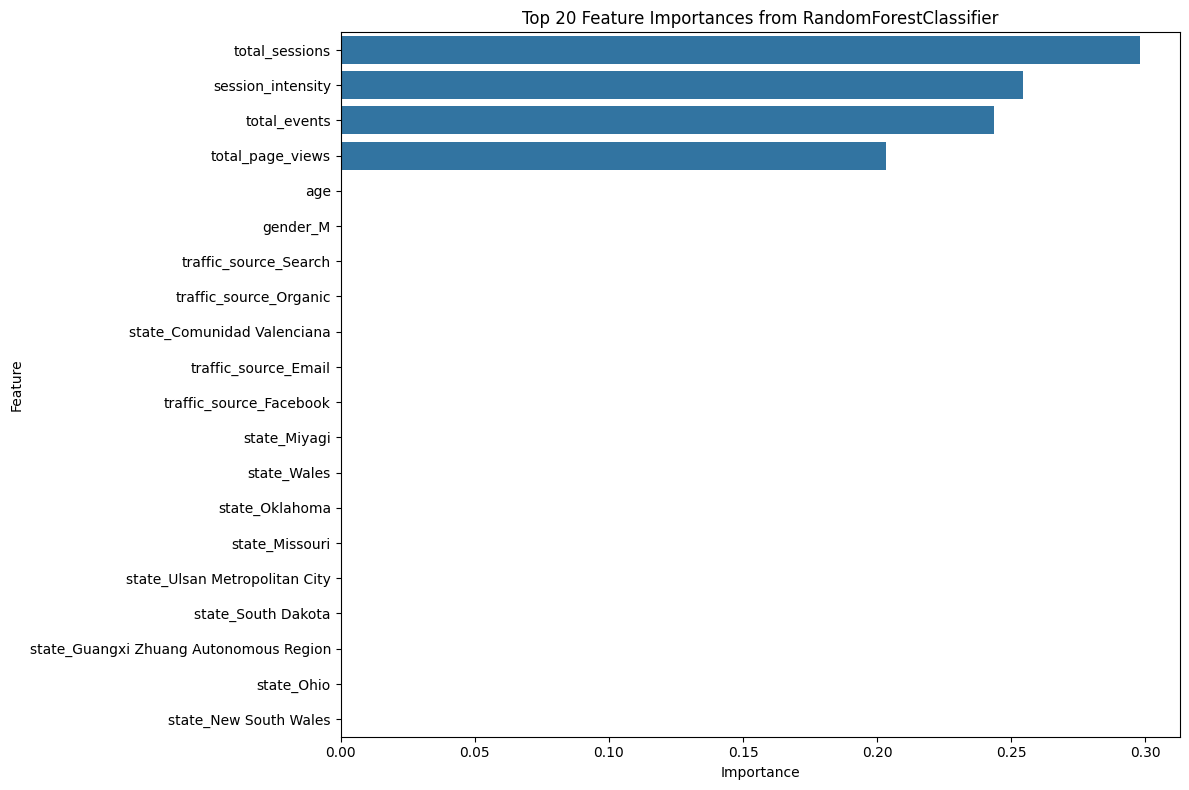

In [ ]:
# Feature Importance
feature_importances = model.feature_importances_
features = X_encoded.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from RandomForestClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Summarize the data ingestion process after the corrected query has been executed and verified.


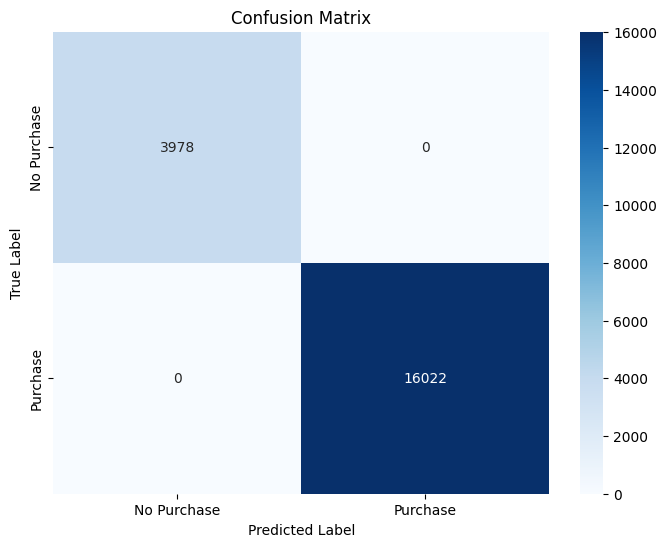


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3978
         1.0       1.00      1.00      1.00     16022

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print Classification Report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

## Summary:

### Q&A
The data ingestion process after the corrected query has been executed and verified was successful. The modified SQL query correctly selected `t1.id` as `user_id` and used it in the `GROUP BY` clause. This query was executed and the results were loaded into a pandas DataFrame `df`. Verification steps using `df.info()` and `df.head()` confirmed that the DataFrame contains 100,000 non-null entries across all 10 columns, with appropriate data types, indicating complete and clean data ingestion.

### Data Analysis Key Findings
*   The SQL query was successfully corrected to select `t1.id` as `user_id` and incorporate it into the `GROUP BY` clause, ensuring proper aggregation of user-specific data.
*   The executed query resulted in a pandas DataFrame, `df`, containing 100,000 entries and 10 columns, including `user_id`, demographic information, and aggregated event metrics.
*   The `df.info()` output confirmed that all 10 columns had 100,000 non-null values, indicating no missing data in the ingested dataset.
*   Data types were appropriately assigned; for example, numerical IDs and counts were `Int64`, while categorical data like `gender`, `state`, `country`, and `traffic_source` were `object` type.
*   The `df.head()` output verified the successful structure and content of the ingested data, displaying the first five rows with user demographics and their corresponding aggregated event features.

### Insights or Next Steps
*   The successfully ingested and verified `df` DataFrame is now clean and ready for immediate exploratory data analysis, feature engineering, or direct use in modeling tasks.
*   The comprehensive nature of the ingested data, combining user demographics with event metrics, provides a solid foundation for customer segmentation, behavior analysis, or predicting future user actions.


**Reasoning**:
To deploy our `RandomForestClassifier` to Vertex AI, I will first save the trained model locally using `joblib`. Then, I will use the Vertex AI SDK to upload this saved model to the Vertex AI Model Registry. After the model is registered, I will deploy it to an endpoint, which makes it available for online predictions. Finally, I will create a synthetic user data point, preprocess it similar to our training data, and send it to the deployed endpoint for a mock prediction to demonstrate the model's functionality.

In [ ]:
import joblib
import os

# Define a model directory and path
MODEL_DIR = 'model_output'
MODEL_PATH = os.path.join(MODEL_DIR, 'model.joblib') # Changed filename to model.joblib

# Create the directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

# Save the trained model
joblib.dump(model, MODEL_PATH)

print(f"Model saved locally to: {MODEL_PATH}")

Model saved locally to: model_output/model.joblib


In [ ]:
import vertexai
from google.cloud import aiplatform

# Define model and endpoint names
MODEL_NAME = 'purchase_probability_rf_model'
ENDPOINT_NAME = 'purchase_probability_rf_endpoint'
aiplatform.init(project=PROJECT_ID, location=REGION)


# Upload the model to Vertex AI Model Registry
# The artifact_uri points to the GCS location where the model is stored.
# For local files, Vertex AI SDK handles the upload to a staging GCS bucket automatically.
model_uploaded = aiplatform.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=MODEL_DIR,
    serving_container_image_uri='us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-5:latest',
    sync=True
)

print(f"Model uploaded: {model_uploaded.resource_name}")

# Create and deploy to an endpoint
endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_NAME, sync=True)

endpoint.deploy(
    model=model_uploaded,
    machine_type='n1-standard-2',
    min_replica_count=1,
    max_replica_count=1,
    sync=True
)

print(f"Model deployed to endpoint: {endpoint.resource_name}")

Model uploaded: projects/1020343113828/locations/us-central1/models/619059131298349056
Model deployed to endpoint: projects/1020343113828/locations/us-central1/endpoints/5268137341163143168


In [ ]:
import pandas as pd
import numpy as np

# Create a mock user data point for prediction
mock_user_data = pd.DataFrame({
    'age': [30],
    'gender': ['F'],
    'state': ['California'],
    'country': ['United States'],
    'traffic_source': ['Search'],
    'total_sessions': [5],
    'total_page_views': [10],
    'total_events': [20],
    'session_intensity': [4.0] # 20 events / 5 sessions
})

# Preprocess the mock user data using the same scaler and one-hot encoder
# Re-create X from original df to ensure all columns are present for get_dummies
X_mock_base = df.drop(columns=['user_id', 'total_purchases'])

# Add the mock user data to X_mock_base to ensure all columns for one-hot encoding are aligned
X_combined = pd.concat([X_mock_base.head(0), mock_user_data], ignore_index=True)

X_mock_encoded = pd.get_dummies(X_combined, columns=categorical_cols, drop_first=True)

# Ensure the mock_user_data has the same columns as X_encoded from training
# This is crucial for consistent input to the deployed model
missing_cols = set(X_encoded.columns) - set(X_mock_encoded.columns)
for c in missing_cols:
    X_mock_encoded[c] = 0

X_mock_encoded = X_mock_encoded[X_encoded.columns] # Reorder columns to match training data

X_mock_encoded[numerical_cols] = scaler.transform(X_mock_encoded[numerical_cols])

print("Mock user data after preprocessing:")
display(X_mock_encoded)

Mock user data after preprocessing:


/tmp/ipython-input-4240580777.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_combined = pd.concat([X_mock_base.head(0), mock_user_data], ignore_index=True)
/tmp/ipython-input-4240580777.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_mock_encoded[c] = 0
/tmp/ipython-input-4240580777.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

,age,total_sessions,total_page_views,total_events,session_intensity,gender_M,state_Aichi,state_Akita,state_Alabama,state_Alagoas,...,country_Japan,country_Poland,country_South Korea,country_Spain,country_United Kingdom,country_United States,traffic_source_Email,traffic_source_Facebook,traffic_source_Organic,traffic_source_Search
0,-0.647714,1.87622,1.018308,0.424329,-1.106184,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Convert preprocessed mock data to a list for prediction
# Vertex AI expects instances as a list of lists or dicts depending on the model type
prediction_instance = X_mock_encoded.iloc[0].tolist()

# Make a mock prediction
predictions = endpoint.predict(instances=[prediction_instance])

print(f"Mock user purchase probability prediction: {predictions.predictions[0]}")

# Clean up the endpoint and model after prediction (optional, but good practice)
# endpoint.undeploy_all()
# endpoint.delete()
# model_uploaded.delete()

print("Deployment and mock prediction complete!")

Mock user purchase probability prediction: 1.0
Deployment and mock prediction complete!


In [ ]:
# Flatten the dataframe to a list for the Vertex AI endpoint
input_data = X_mock_encoded.values.tolist()

# Make the prediction
prediction = endpoint.predict(instances=input_data)
print(f"Prediction for Alan: {prediction.predictions}")

Prediction for Alan: [1.0]
